# Creating your own EOF code from scratch
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/eof_from_scratch.ipynb)

Demonstration of how to code up EOF analysis from start to finish.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))


IN_COLAB = False


In [2]:
if IN_COLAB:
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !apt-get -qq install python-cartopy python3-cartopy
    !pip uninstall -y shapely    
    !pip install shapely --no-binary shapely    


import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.linalg as LA
import scipy.io as sio
import xarray as xr
import pandas as pd

from matplotlib.patches import Polygon
import matplotlib as mpl
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

In [3]:
#-------------------------------------------------------
# set figure defaults
fig_text_default = 12.
fig_title_default = fig_text_default*1.1
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100


### Data Description

This data is composed of 7 weather variables averaged over one year for each state in the US (thus, 50 states). There is also an option to comment this out and instead use a matrix of random data (just for comparison).

In [4]:
#-----------MODIFY--------------------------
# use random data instead of real data?
fakeData = False

In [5]:
# names of the different variables for each state
descriptor_names = ['temp','precip','% sun','sun hours','clear dys','humid AM','humid PM']

# load the data
if IN_COLAB:
    !wget https://github.com/eabarnes1010/course_objective_analysis/raw/main/data/state_data_raw.mat
    DATA = sio.loadmat('state_data_raw.mat')    
else:    
    DATA = sio.loadmat('../data/state_data_raw.mat')
Y = DATA['X']

if(fakeData==True):
    Y = np.random.rand(np.size(Y,axis=0),np.size(Y,axis=1))

In [6]:
# look at the data
# rows = states in the U.S.
# columns = annual-mean weather info
df = pd.DataFrame(Y, columns=descriptor_names)
df

,temp,precip,% sun,sun hours,clear dys,humid AM,humid PM
0,62.8,58.3,58.0,2641.0,99.0,84.0,52.0
1,26.6,22.5,41.0,2061.0,61.0,77.0,64.0
2,60.3,13.6,85.0,3806.0,193.0,53.0,25.0
3,60.4,50.6,61.0,2771.0,123.0,85.0,49.0
4,59.4,22.2,68.0,3055.0,146.0,76.0,62.0
5,45.1,15.9,71.0,3204.0,136.0,60.0,35.0
6,49.0,50.3,56.0,2585.0,82.0,79.0,52.0
7,55.3,45.7,NaN,NaN,97.0,79.0,54.0
8,70.7,54.5,66.0,2927.0,101.0,87.0,57.0
9,63.5,50.7,66.0,2986.0,112.0,86.0,50.0


### Process your data into anomalies and decide whether to standardize or not

One decision you need to make is whether you wish to standardize your data. In this example, the 7 weather variables all have very different units. Thus, if you don't standardize your data the variable with the largest units will likely dominate the EOF calculation - and this is obviously not what we want. So, I standardize. However, note you can uncomment one of the lines if you want to see what happens when you do not standardize.

In [7]:
# calculate anomalies from the state-mean (sample-mean) - call this "X"
Ymean = np.nanmean(Y,axis = 0)
X = Y - Ymean

In [8]:
# standardize the data - call it "Xw"
Xstd = np.nanstd(X,axis = 0)
Xw = X/Xstd

# UNCOMMENT if you don't want to standardize the data
#Xw = X;

### Calculate EOF using temporal covariance matrix (covariance along the sampling dimension)

In [9]:
# define my own dot product function for when there are NaNs. 
# Note that this does the scaling by 1/M inside it (by taking nanmean), so not a true dot product.
def nandot(X,Y):
    
    C = np.empty([np.size(X,axis=0),np.size(Y,axis=1)])
    for row in np.arange(0,np.size(X,axis=0)):
        for col in np.arange(0,np.size(Y,axis=1)):
            C[row,col] = np.nanmean(np.multiply(X[row,:],Y[:,col]))
            
    return C

In [10]:
# If No NaNs: calculate the temporal covariance matrix, dimensions should be [7 x 7]
#C = 1./np.size(Xw,axis = 0)*np.dot(np.transpose(Xw),Xw) 

# If there ARE NaNs:
# calculate the scaled temporal covariance matrix by hand to ignore the NaNs, dimensions should be [7 x 7]
C = nandot(np.transpose(Xw),Xw) 

print(C)

[[ 1.          0.54408661  0.4414842   0.32948218  0.37458539  0.21872046
  -0.10306989]
 [ 0.54408661  1.         -0.33037555 -0.47090245 -0.39337431  0.64439514
   0.5403986 ]
 [ 0.4414842  -0.33037555  1.          0.9785408   0.89338975 -0.59804246
  -0.81286433]
 [ 0.32948218 -0.47090245  0.9785408   1.          0.92730696 -0.61577507
  -0.86866918]
 [ 0.37458539 -0.39337431  0.89338975  0.92730696  1.         -0.52428887
  -0.77892432]
 [ 0.21872046  0.64439514 -0.59804246 -0.61577507 -0.52428887  1.
   0.7324305 ]
 [-0.10306989  0.5403986  -0.81286433 -0.86866918 -0.77892432  0.7324305
   1.        ]]


In [11]:
# calculate eigenvalues and eigenvectors of C; lam should be 7x1, E should be 7x7
lam, E = LA.eig(C) 

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:,i]

In [12]:
# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)

### Plot the results: eigenvalue spectrum

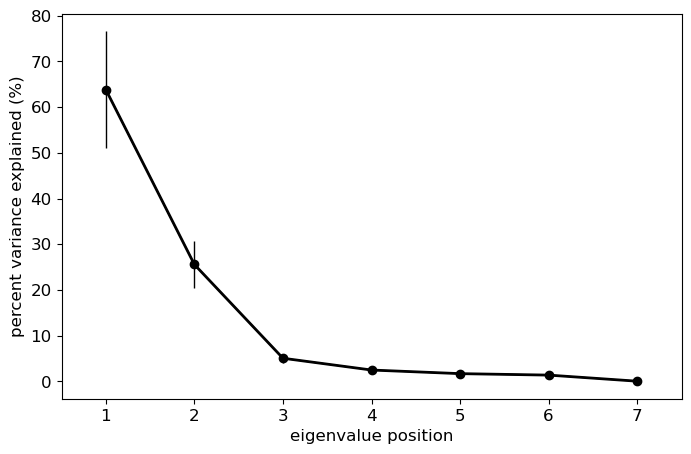

In [13]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 2, color = 'black')

plt.xlim(0.5, 7.5)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 0)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb, xerr = None, linewidth = 1, color = 'black')

plt.show()

### Calculate PC timeseries and scaled EOF (called "d")

In [14]:
#========== MODIFY =============
# which EOF do you want to plot?
eof_num = 1
#===============================

# take only one eigenvector, user specified by "eof_num" above
e1 = E[:,eof_num-1] #e1 should be 7x1 or 1x7 depending on your software

# calculate the the PC associated with the EOF of interest
z1 = np.dot(Xw,e1) #z1 should be 50x1 or 1x50 depending on your software

# standardize z1
z1 = (z1-np.nanmean(z1))/np.nanstd(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units,
# thus it uses the original "X" anomaly data

#if no NaNs in data, I could use this
#d1 = (1./np.size(X,axis=0))*np.dot(np.transpose(z1),X)
# If there ARE NaNs:
d1 = nandot(np.matrix(z1),X).T

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data

# If no NaNs in data, I could use this
# d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)
# If there ARE NaNs:
d1s = nandot(np.matrix(z1),Xw).T

### Plot the results: EOF in standardized units

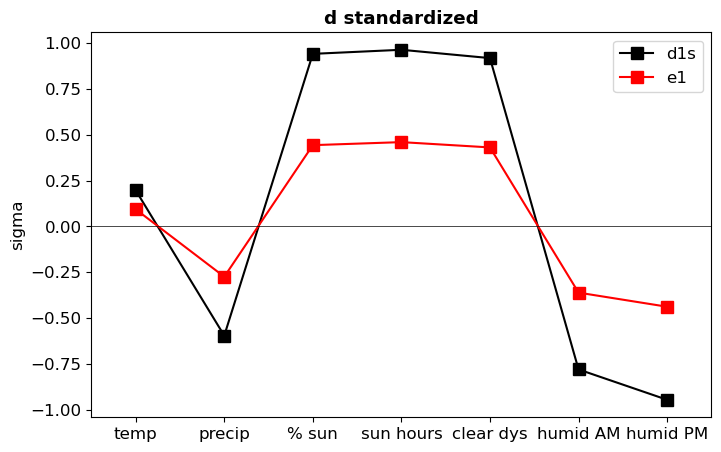

In [15]:
plt.figure(figsize=(8,5))

plt.plot(d1s,'s-k', label = 'd' + str(eof_num) + 's', markersize=8)
plt.plot(e1,'s-r', label = 'e' + str(eof_num), markersize=8)

plt.xticks(np.arange(len(descriptor_names)),descriptor_names, fontsize = 12)
plt.xlim(-0.5, 6.5)

plt.legend()
plt.axhline(color='k',linewidth=.5)
plt.ylabel('sigma')
plt.title('d standardized')

plt.show()

### Plot the results: EOF in physical units

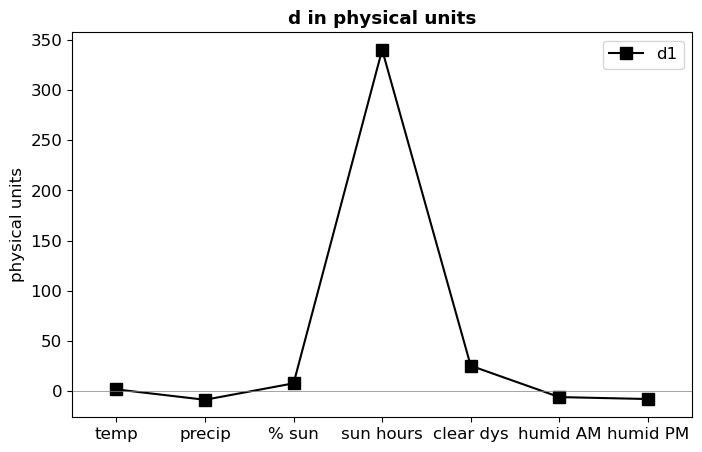

In [16]:
plt.figure(figsize=(8,5))
plt.plot(d1,'s-k',label = 'd' + str(eof_num), markersize=8)

plt.xticks(np.arange(len(descriptor_names)),descriptor_names)
plt.axhline(color='gray',linewidth=.5)
plt.legend()
plt.ylabel('physical units')
plt.title('d in physical units')
plt.xlim(-0.5, 6.5)

plt.show()

### Plot the results: PC as a U.S. map

Cartopy was throwing lots of errors trying to get the shapefile for the states, so I downloaded it myself. The file comes from the following website
* https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

With the exact download link provided below
* https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_1_states_provinces.zip

/opt/homebrew/Caskroom/miniforge/base/envs/env-ats655/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniforge/base/envs/env-ats655/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


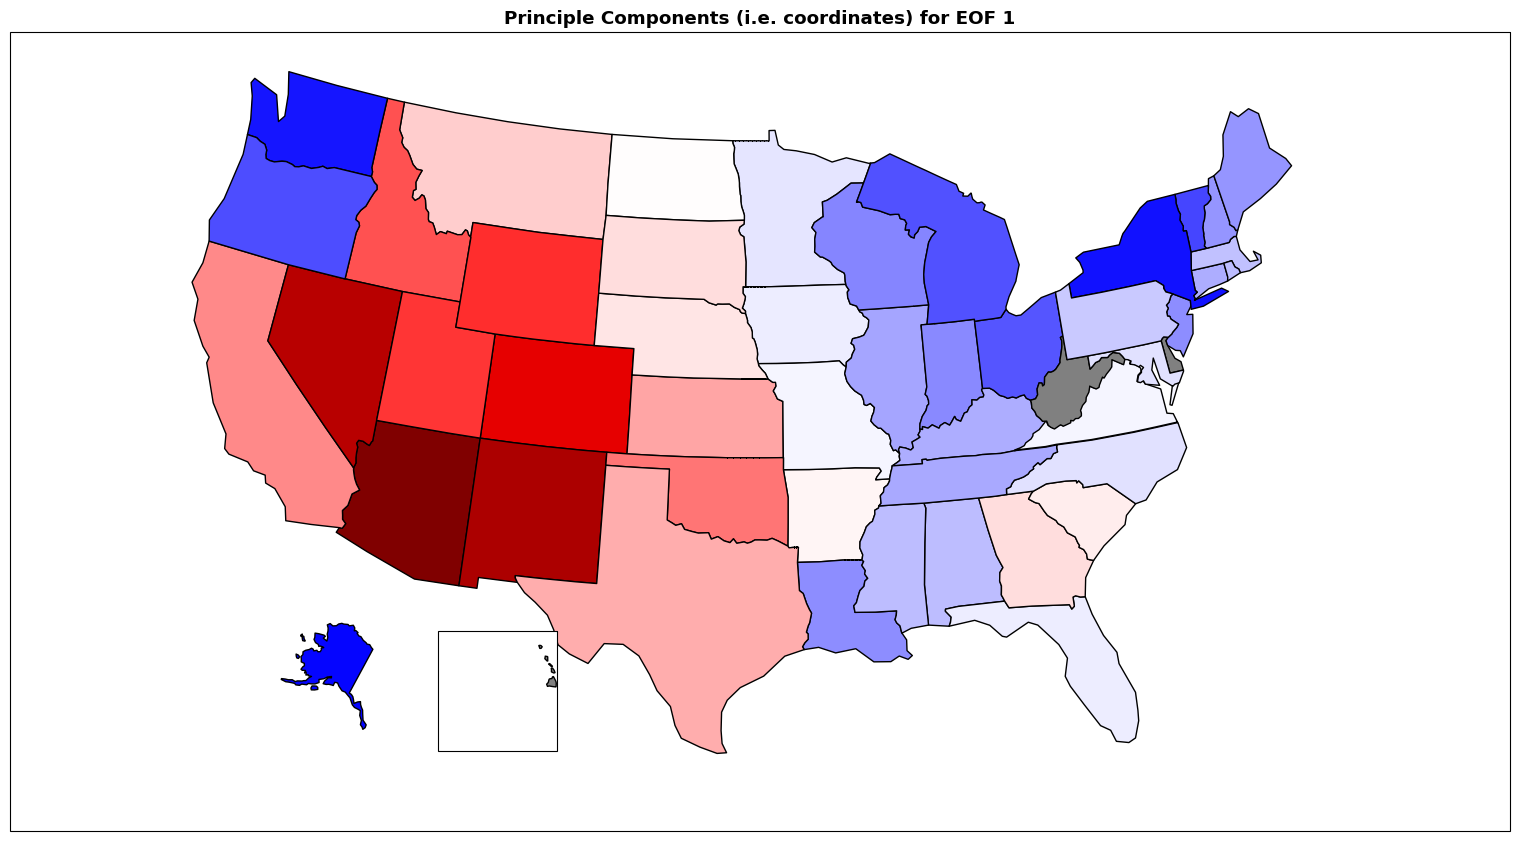

In [18]:
!pip install wget
import wget

fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

plt.title('Principle Components (i.e. coordinates) for EOF ' + str(eof_num))    
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

states_shp = wget.download("https://raw.githubusercontent.com/eabarnes1010/course_objective_analysis/main/data/ne_110m_admin_1_states_provinces.zip")
cmap = plt.cm.get_cmap('seismic')
state_names = []
vmin = -3.
vmax = 3.

for astate in shpreader.Reader(states_shp).records():
    state_names.append(astate.attributes['name'])

state_names_list = sorted(list(set(state_names)))
state_names_list.pop(state_names_list.index('District of Columbia'))

for astate in shpreader.Reader(states_shp).records():
    
    statename = astate.attributes['name']
    if(statename == 'District of Columbia'):
        continue
    # use the name of this state to get pop_density
    z = z1[state_names_list.index(statename)]
    clr = cmap((z-vmin)/(vmax-vmin))[:3]
    if(np.isnan(z)):
        clr = 'gray'
    
    if statename == 'Alaska':
    # Alaska is too big. Scale it down to 35% first, then transate it. 
        axak = fig.add_axes([0.1, 0.1, 0.2, 0.2], projection=ccrs.LambertConformal())
        axak.set_extent([-185, -130, 70, 50])
        axak.add_geometries([astate.geometry], ccrs.PlateCarree(),
                  facecolor=clr, edgecolor='k')
    elif statename == 'Hawaii':
        axhi = fig.add_axes([0.25, .1, 0.15, 0.15], projection=ccrs.LambertConformal())
        axhi.set_extent([-155, -165, 10, 20])
        axhi.add_geometries([astate.geometry], ccrs.PlateCarree(),
                  facecolor=clr, edgecolor='k')
    else:        
        # `astate.geometry` is the polygon to plot
        ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                          facecolor=clr, edgecolor='k')

plt.box(False)
# for subplot in [axak, axhi]:
#     subplot.background_patch.set_visible(False)
#     subplot.outline_patch.set_visible(False)

plt.show()


These PC values show how much a given state "looks" like the EOF structure above. Dark blue and dark red denote large opposite signed values (remember, the sign itself doesn't matter here - just the relationships between values/signs across states).